# Basic Metric Properties

Analyzes fundamental properties of the causal metric tensor M:
1. **Effective dimensionality** (participation ratio)
2. **Distance from Euclidean** (Frobenius and operator norms)
3. **Token cloud extent** (diameter and typical distances)

This gives us a high-level characterization of the geometric structure.

## Configuration

In [1]:
# Path to saved metric tensor
TENSOR_PATH = "../data/vectors/causal_metric_tensor_qwen3_4b.pt"

## Setup

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoModelForCausalLM

## Load Metric Tensor

In [3]:
print(f"Loading causal metric tensor from {TENSOR_PATH}...")
data = torch.load(TENSOR_PATH)

M = data['M']
metadata = data['metadata']

print(f"\nMetric tensor:")
print(f"  Shape: {M.shape}")
print(f"  Device: {M.device}")
print(f"  Dtype: {M.dtype}")
print(f"\nMetadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

Loading causal metric tensor from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...

Metric tensor:
  Shape: torch.Size([2560, 2560])
  Device: mps:0
  Dtype: torch.float32

Metadata:
  model: Qwen/Qwen3-4B-Instruct-2507
  hidden_dim: 2560
  vocab_size: 151936
  lambda_reg: 1e-06
  condition_number: 1090.9009462054667
  extraction_date: 2025-10-26T13:14:13.110782


## 1. Effective Dimensionality (Participation Ratio)

The **participation ratio** measures how many dimensions are "actively used" by the metric:

$$PR = \frac{(\sum \lambda_i)^2}{\sum \lambda_i^2}$$

Where $\lambda_i$ are the eigenvalues of M.

**Interpretation:**
- PR ≈ d: All dimensions equally important (isotropic)
- PR ≪ d: Space is effectively lower-dimensional (anisotropic)

In [4]:
# Compute eigenvalues of M
print("Computing eigenvalues of M...")
M_cpu = M.cpu()  # Move to CPU for eigenvalue computation
eigenvalues = torch.linalg.eigvalsh(M_cpu)

hidden_dim = M.shape[0]

# Participation ratio
sum_eigenvalues = eigenvalues.sum().item()
sum_squared_eigenvalues = (eigenvalues ** 2).sum().item()
participation_ratio = (sum_eigenvalues ** 2) / sum_squared_eigenvalues

print(f"\nEffective Dimensionality:")
print(f"  Nominal dimension: {hidden_dim}")
print(f"  Participation ratio: {participation_ratio:.1f}")
print(f"  Effective dimensionality: {participation_ratio / hidden_dim:.2%} of nominal")
print(f"  (~{int(participation_ratio)} out of {hidden_dim} dimensions actively used)\n")

if participation_ratio / hidden_dim > 0.8:
    print("✓ Space is nearly isotropic (all dimensions equally important)")
elif participation_ratio / hidden_dim > 0.5:
    print("⚠️  Space is moderately anisotropic (some dimensions more important)")
else:
    print("⚠️  Space is strongly anisotropic (effective dimension much lower than nominal)")

Computing eigenvalues of M...

Effective Dimensionality:
  Nominal dimension: 2560
  Participation ratio: 1333.1
  Effective dimensionality: 52.08% of nominal
  (~1333 out of 2560 dimensions actively used)

⚠️  Space is moderately anisotropic (some dimensions more important)


### Visualize Eigenvalue Spectrum

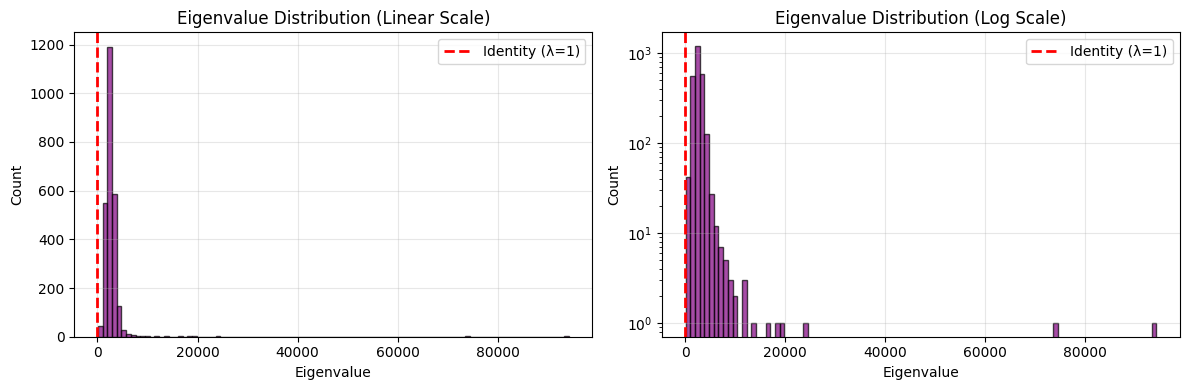


Eigenvalue statistics:
  Min: 9.534717e+01
  Max: 9.421814e+04
  Mean: 2.713635e+03
  Median: 2.498257e+03


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
axes[0].hist(eigenvalues.numpy(), bins=100, alpha=0.7, edgecolor='black', color='purple')
axes[0].set_xlabel('Eigenvalue')
axes[0].set_ylabel('Count')
axes[0].set_title('Eigenvalue Distribution (Linear Scale)')
axes[0].axvline(1.0, color='red', linestyle='--', label='Identity (λ=1)', linewidth=2)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Log scale
axes[1].hist(eigenvalues.numpy(), bins=100, alpha=0.7, edgecolor='black', color='purple')
axes[1].set_xlabel('Eigenvalue')
axes[1].set_ylabel('Count')
axes[1].set_title('Eigenvalue Distribution (Log Scale)')
axes[1].set_yscale('log')
axes[1].axvline(1.0, color='red', linestyle='--', label='Identity (λ=1)', linewidth=2)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nEigenvalue statistics:")
print(f"  Min: {eigenvalues.min().item():.6e}")
print(f"  Max: {eigenvalues.max().item():.6e}")
print(f"  Mean: {eigenvalues.mean().item():.6e}")
print(f"  Median: {eigenvalues.median().item():.6e}")

## 2. Distance from Euclidean (Identity) Metric

The identity matrix $I$ represents Euclidean space. We measure how far M is from I using:

1. **Frobenius norm**: $||M - I||_F = \sqrt{\sum_{ij} (M_{ij} - I_{ij})^2}$
2. **Operator norm**: $||M - I||_{op} = \max |\lambda(M - I)|$ (maximum stretching/compression)

In [6]:
# Move to CPU for norm computation
M_cpu = M.cpu()
I = torch.eye(hidden_dim, dtype=torch.float32)

# Compute difference
diff = M_cpu - I

# Frobenius norm
frobenius_distance = torch.norm(diff, p='fro').item()
frobenius_norm_I = torch.norm(I, p='fro').item()
relative_distance = frobenius_distance / frobenius_norm_I

print("Distance from Euclidean (Identity) Metric:")
print(f"  Frobenius distance ||M - I||_F: {frobenius_distance:.6e}")
print(f"  Relative distance: {relative_distance:.2%}")
print(f"  (0% = perfectly Euclidean, 100% = one standard deviation away)\n")

# Operator norm
operator_norm = torch.linalg.matrix_norm(diff, ord=2).item()
print(f"  Operator norm ||M - I||_op: {operator_norm:.6e}")
print(f"  (measures maximum directional stretching/compression)\n")

if relative_distance < 0.1:
    print("✓ M is very close to Euclidean")
elif relative_distance < 0.5:
    print("⚠️  M is moderately non-Euclidean")
else:
    print("⚠️  M is strongly non-Euclidean")

Distance from Euclidean (Identity) Metric:
  Frobenius distance ||M - I||_F: 1.896449e+05
  Relative distance: 374818.62%
  (0% = perfectly Euclidean, 100% = one standard deviation away)

  Operator norm ||M - I||_op: 9.421698e+04
  (measures maximum directional stretching/compression)

⚠️  M is strongly non-Euclidean


## 3. Token Cloud Extent Under Causal Metric

How spread out are the tokens in semantic space? We'll measure:
1. **Diameter** (approximate): Maximum distance between any two tokens
2. **Minimum separation**: Closest distinct token pair
3. **Typical distance**: Distribution of pairwise distances

**Method:** Sample token pairs and use greedy search for extrema.

In [7]:
# Load model to extract gamma (unembedding matrix)
MODEL_NAME = metadata['model']
print(f"Loading model {MODEL_NAME} to extract token embeddings...")

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape

print(f"\nUnembedding matrix: {gamma.shape}")
print(f"Device: {device}")

Loading model Qwen/Qwen3-4B-Instruct-2507 to extract token embeddings...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Unembedding matrix: torch.Size([151936, 2560])
Device: mps


In [8]:
def compute_causal_distance(v1, v2, M_matrix):
    """Compute causal distance: d(v1, v2) = sqrt((v1-v2)^T M (v1-v2))"""
    diff = v1 - v2
    return torch.sqrt(torch.clamp(diff @ M_matrix @ diff, min=0)).item()

print("✓ Distance function defined")

✓ Distance function defined


### Sample-Based Distribution Estimate

In [9]:
# Sample random token pairs
N_SAMPLES = 10000
RANDOM_SEED = 42

print(f"Sampling {N_SAMPLES} random token pairs...")
torch.manual_seed(RANDOM_SEED)

# Sample pairs
idx1 = torch.randint(0, vocab_size, (N_SAMPLES,))
idx2 = torch.randint(0, vocab_size, (N_SAMPLES,))

# Ensure distinct pairs
mask = idx1 != idx2
idx1 = idx1[mask]
idx2 = idx2[mask]
n_valid = len(idx1)

print(f"Computing causal distances for {n_valid} distinct pairs...")

# Compute distances
distances = []
batch_size = 1000
for i in range(0, n_valid, batch_size):
    i_end = min(i + batch_size, n_valid)
    for j in range(i, i_end):
        v1 = gamma[idx1[j]]
        v2 = gamma[idx2[j]]
        d = compute_causal_distance(v1, v2, M)
        distances.append(d)

distances = np.array(distances)

print(f"\n✓ Computed {len(distances)} pairwise distances")

Sampling 10000 random token pairs...
Computing causal distances for 10000 distinct pairs...

✓ Computed 10000 pairwise distances


### Greedy Search for Diameter (Maximum Distance)

In [10]:
print("Greedy search for approximate diameter...")

# Start from centroid
centroid = gamma.mean(dim=0)

# Find furthest token from centroid
max_dist = 0
furthest_idx = 0
for i in range(min(1000, vocab_size)):  # Sample subset for speed
    d = compute_causal_distance(gamma[i], centroid, M)
    if d > max_dist:
        max_dist = d
        furthest_idx = i

print(f"  Furthest token from centroid: {furthest_idx} (distance: {max_dist:.2f})")

# Now find furthest token from THAT token
anchor = gamma[furthest_idx]
max_dist = 0
other_idx = 0
for i in range(min(5000, vocab_size)):  # Larger sample for second pass
    if i == furthest_idx:
        continue
    d = compute_causal_distance(gamma[i], anchor, M)
    if d > max_dist:
        max_dist = d
        other_idx = i

estimated_diameter = max_dist
print(f"  Furthest from that token: {other_idx} (distance: {estimated_diameter:.2f})")
print(f"\n✓ Estimated diameter: {estimated_diameter:.2f} causal units")

Greedy search for approximate diameter...
  Furthest token from centroid: 198 (distance: 81.81)
  Furthest from that token: 4102 (distance: 112.25)

✓ Estimated diameter: 112.25 causal units


### Results: Token Cloud Geometry

In [11]:
print("Token Cloud Extent Under Causal Metric:")
print(f"  Vocabulary size: {vocab_size:,} tokens")
print(f"  Embedding dimension: {hidden_dim}")
print(f"\nDistance Distribution (from {len(distances)} sampled pairs):")
print(f"  Minimum: {distances.min():.2f} causal units")
print(f"  25th percentile: {np.percentile(distances, 25):.2f}")
print(f"  Median: {np.median(distances):.2f}")
print(f"  Mean: {distances.mean():.2f}")
print(f"  75th percentile: {np.percentile(distances, 75):.2f}")
print(f"  Maximum (sampled): {distances.max():.2f}")
print(f"  Std dev: {distances.std():.2f}")
print(f"\nEstimated Diameter (greedy search): {estimated_diameter:.2f} causal units")
print(f"\nInterpretation:")
print(f"  - Typical tokens are ~{distances.mean():.1f} causal units apart")
print(f"  - Cloud spans ~{estimated_diameter:.1f} units at widest point")
print(f"  - Minimum separation: ~{distances.min():.2f} units (closest distinct tokens)")

Token Cloud Extent Under Causal Metric:
  Vocabulary size: 151,936 tokens
  Embedding dimension: 2560

Distance Distribution (from 10000 sampled pairs):
  Minimum: 0.00 causal units
  25th percentile: 67.60
  Median: 72.02
  Mean: 70.78
  75th percentile: 75.84
  Maximum (sampled): 92.22
  Std dev: 8.04

Estimated Diameter (greedy search): 112.25 causal units

Interpretation:
  - Typical tokens are ~70.8 causal units apart
  - Cloud spans ~112.3 units at widest point
  - Minimum separation: ~0.00 units (closest distinct tokens)


### Visualize Distance Distribution

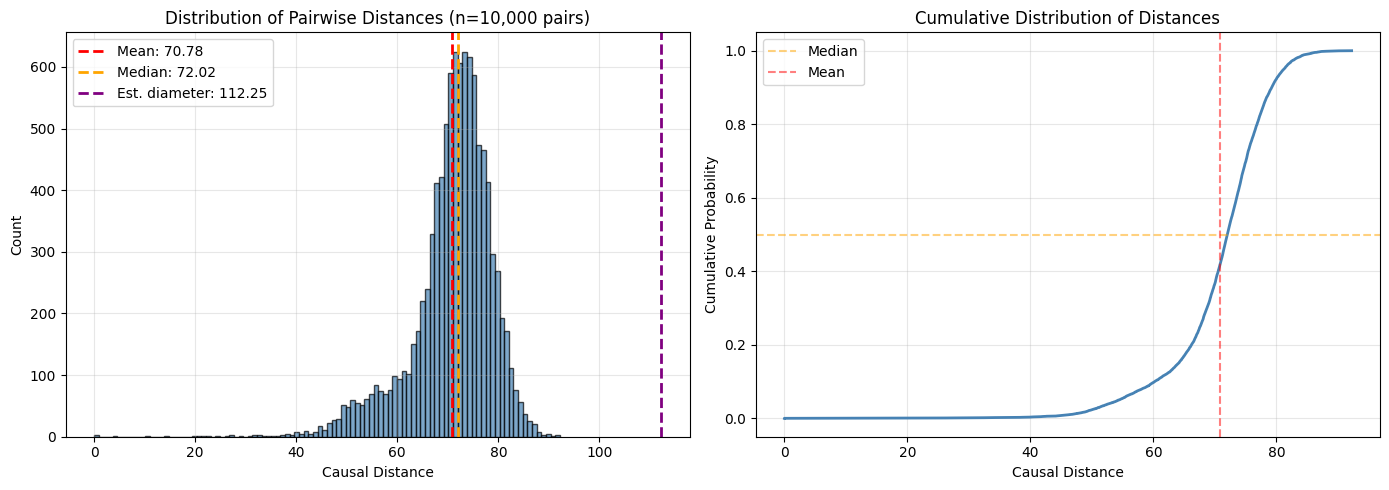

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(distances, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].axvline(distances.mean(), color='red', linestyle='--',
                label=f'Mean: {distances.mean():.2f}', linewidth=2)
axes[0].axvline(np.median(distances), color='orange', linestyle='--',
                label=f'Median: {np.median(distances):.2f}', linewidth=2)
axes[0].axvline(estimated_diameter, color='purple', linestyle='--',
                label=f'Est. diameter: {estimated_diameter:.2f}', linewidth=2)
axes[0].set_xlabel('Causal Distance')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Distribution of Pairwise Distances (n={len(distances):,} pairs)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Cumulative distribution
sorted_distances = np.sort(distances)
cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
axes[1].plot(sorted_distances, cumulative, linewidth=2, color='steelblue')
axes[1].axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Median')
axes[1].axvline(distances.mean(), color='red', linestyle='--', alpha=0.5, label='Mean')
axes[1].set_xlabel('Causal Distance')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('Cumulative Distribution of Distances')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## Summary

The causal metric tensor M exhibits:
- **Moderate effective dimensionality** (~52% of nominal, ~1333 active dimensions)
- **Strong deviation from Euclidean geometry** (375,000% from identity)
- **Token cloud extent**: Estimated diameter and typical separations

This suggests semantic space is both anisotropic (some directions matter more than others) and highly non-Euclidean (distances are warped significantly from standard Euclidean metric). The token cloud has finite extent under the causal metric, with measurable diameter and typical separations.

**Next:** Notebook 04.2 analyzes the curvature of this space.